In [ ]:
import torch as th
import pandas as pd
import torch.nn as nn
import torch.nn.functional as f
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torchvision.transforms as transform
!pip install torch_summary
from torchsummary import summary
import cv2 as cv
device= 'cuda' if  th.cuda.is_available() else 'cpu'
print(device)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cuda


In [ ]:
import os
from google.colab import drive
drive.mount('/content/gdrive')
os.chdir('/content/gdrive/MyDrive/NAAMII/')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
data=pd.read_csv("Data.csv")
data=data.iloc[:,1:]
print(len(data))
print(data)

87
                                   folder  label
0   BBS1/425-1-3_OS_V_2x2_0_RegAvg0000021    0.0
1     WT/183-2-8_OS_V_2x2_0_RegAvg0000009    1.0
2     WT/439-1-2_OS_V_2x2_0_RegAvg0000023    1.0
3     WT/427-1-8_OS_V_2X2_0_REGAVG0000023    1.0
4     WT/202-1-6_OS_V_2x2_0_RegAvg0000024    1.0
..                                    ...    ...
82    WT/427-1-6_OS_V_2X2_0_REGAVG0000023    1.0
83  BBS1/502-1-1_OS_V_2x2_0_RegAvg0000023    0.0
84    WT/446-1-2_OS_V_2x2_0_RegAvg0000016    1.0
85    WT/439-1-1_OS_V_2x2_0_RegAvg0000023    1.0
86    WT/315-1-5_OS_V_2x2_0_RegAvg0000023    1.0

[87 rows x 2 columns]


(224, 224, 3)


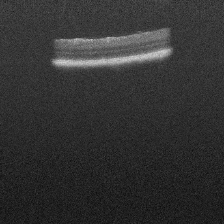

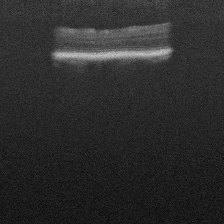

In [ ]:
from google.colab.patches import cv2_imshow
frame_no="Frame_10.JPG"
images="Images"
image_path=os.path.join(data.iloc[0,0],"Images",frame_no)
image_path2=os.path.join(data.iloc[1,0],"Images",frame_no)
image=cv.imread(image_path)
image2=cv.imread(image_path2)
image=cv.resize(image,(224,224))
image2=cv.resize(image2,(224,224))
print(image.shape)
cv2_imshow(image)
cv2_imshow(image2)

In [ ]:
frame_no=[]
for i in range(5,100,12):
  frame_no.append(f"Frame_{i}.JPG")
#print(frame_no)
image_path=os.path.join(data.iloc[0,0],"Images",frame_no[0])
image=cv.imread(image_path)
image=th.tensor(cv.resize(image,(224,224)))
image=image.permute(2,0,1)
img=image
for i in range(1,len(frame_no)):
  image_path=os.path.join(data.iloc[0,0],"Images",frame_no[i])
  image=cv.imread(image_path)
  image=th.tensor(cv.resize(image,(224,224)))
  image=image.permute(2,0,1)
  img=th.cat((img,image),axis=0)
print(img.shape)
target=th.tensor(data.iloc[0,1])
print(target)

torch.Size([24, 224, 224])
tensor(0., dtype=torch.float64)


In [ ]:
from torch.utils.data import TensorDataset, DataLoader, Dataset
class ImageData(Dataset):
    def __init__(self, df):
        super(DataLoader).__init__()
        self.df = df
        self.normalize = transform.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
    def __len__(self): return len(self.df)
    def __getitem__(self, ix):
        frame_no=[]
        for i in range(5,100,12):
          frame_no.append(f"Frame_{i}.JPG")
        image_path=os.path.join(self.df.iloc[ix,0],"Images",frame_no[0])
        image=cv.imread(image_path)
        image=(cv.resize(image,(299,299)))
        image=image/np.max(image)
        image=th.tensor(image)
        image=image.permute(2,0,1)
        image=self.normalize(image)
        img=image
        for i in range(1,len(frame_no)):
          image_path=os.path.join(self.df.iloc[ix,0],"Images",frame_no[i])
          image=cv.imread(image_path)
          image=(cv.resize(image,(299,299)))
          image=image/np.max(image)
          image=th.tensor(image)
          image=image.permute(2,0,1)
          image=self.normalize(image)
          img=th.cat((img,image),axis=0)
        target=self.df.iloc[ix,1]
        return img.float().to(device),th.tensor([target]).float().to(device)


In [ ]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size=0.2)
train_dataset = ImageData(train.reset_index(drop=True))
test_dataset = ImageData(test.reset_index(drop=True))
train_loader = DataLoader(train_dataset, batch_size=3)
test_loader = DataLoader(test_dataset, batch_size=3)

In [ ]:
class InceptionModel(nn.Module):
 def __init__(self,num_classes):
    super(InceptionModel,self).__init__()
    self.outputClasses=num_classes
 def getmodel(self):
    weights=torchvision.models.Inception_V3_Weights.IMAGENET1K_V1
    model=torchvision.models.inception_v3(weights)
    model.aux_logits = False
    #The weights of the pretrained models are not trainable
    for params in model.parameters():
      params.require_grad=False
    model.fc=nn.Sequential(
        nn.Linear(model.fc.in_features, 2000),
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Linear(2000,1000),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(1000,500),
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Linear(500,250),
        nn.ReLU(),
        nn.Linear(250,1)
    )
    return model

In [ ]:
from torchsummary import summary
inception=InceptionModel(2)
model=inception.getmodel()
summary(model,(24,224,224))

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


Layer (type:depth-idx)                   Output Shape              Param #
├─BasicConv2d: 1-1                       [-1, 32, 111, 111]        --
|    └─Conv2d: 2-1                       [-1, 32, 111, 111]        864
|    └─BatchNorm2d: 2-2                  [-1, 32, 111, 111]        64
├─BasicConv2d: 1-2                       [-1, 32, 109, 109]        --
|    └─Conv2d: 2-3                       [-1, 32, 109, 109]        9,216
|    └─BatchNorm2d: 2-4                  [-1, 32, 109, 109]        64
├─BasicConv2d: 1-3                       [-1, 64, 109, 109]        --
|    └─Conv2d: 2-5                       [-1, 64, 109, 109]        18,432
|    └─BatchNorm2d: 2-6                  [-1, 64, 109, 109]        128
├─MaxPool2d: 1-4                         [-1, 64, 54, 54]          --
├─BasicConv2d: 1-5                       [-1, 80, 54, 54]          --
|    └─Conv2d: 2-7                       [-1, 80, 54, 54]          5,120
|    └─BatchNorm2d: 2-8                  [-1, 80, 54, 54]          160
├─

Layer (type:depth-idx)                   Output Shape              Param #
├─BasicConv2d: 1-1                       [-1, 32, 111, 111]        --
|    └─Conv2d: 2-1                       [-1, 32, 111, 111]        864
|    └─BatchNorm2d: 2-2                  [-1, 32, 111, 111]        64
├─BasicConv2d: 1-2                       [-1, 32, 109, 109]        --
|    └─Conv2d: 2-3                       [-1, 32, 109, 109]        9,216
|    └─BatchNorm2d: 2-4                  [-1, 32, 109, 109]        64
├─BasicConv2d: 1-3                       [-1, 64, 109, 109]        --
|    └─Conv2d: 2-5                       [-1, 64, 109, 109]        18,432
|    └─BatchNorm2d: 2-6                  [-1, 64, 109, 109]        128
├─MaxPool2d: 1-4                         [-1, 64, 54, 54]          --
├─BasicConv2d: 1-5                       [-1, 80, 54, 54]          --
|    └─Conv2d: 2-7                       [-1, 80, 54, 54]          5,120
|    └─BatchNorm2d: 2-8                  [-1, 80, 54, 54]          160
├─

In [ ]:
criterion=nn.BCEWithLogitsLoss()
optimizer=th.optim.Adam(model.parameters(),lr=0.001)

In [ ]:
def train_batch(img, target, model, optimizer, criterion):
  model.train()
  optimizer.zero_grad()
  output = model(img)
  loss = criterion(output, target.to(device))
  loss.backward()
  optimizer.step()
  return loss
def accuracy(x, y, model):
  model.eval()
  with th.no_grad():
    prediction = model(x)
  is_correct = (prediction > 0.5) == y
  return is_correct.cpu().numpy().tolist()

In [ ]:
def validate_batch(img, target, model, criterion):
  model.eval()
  with th.no_grad():
    output = model(img)
  loss = criterion(output, target.to(device))
  return output, loss

In [ ]:
train_loss, test_loss = [], []
n_epochs = 30
train_accuracies = []
val_accuracies = []
for epoch in range(n_epochs):
  epoch_train_loss, epoch_test_loss = 0, 0
  train_epoch_accuracies = []
  val_epoch_accuracies = []
  count=0
  for img,target in train_loader:
    loss = train_batch(img, target, model, optimizer, criterion)
    epoch_train_loss += loss.item()
    count=count+1
  epoch_train_loss /= (count)
  count=0
  for batch in train_loader:
    x, y = batch
    is_correct = accuracy(x, y, model)
    train_epoch_accuracies.extend(is_correct)
  train_epoch_accuracy = np.mean(train_epoch_accuracies)
  count=0
  for img,target in test_loader:
    ps, loss = validate_batch(img, target, model, criterion)
    epoch_test_loss += loss.item()
    count=count+1
  epoch_test_loss /= (count)
  for  batch in test_loader:
    x, y = batch
    val_is_correct = accuracy(x, y, model)
    val_epoch_accuracies.extend(val_is_correct)
  val_epoch_accuracy = np.mean(val_epoch_accuracies)
  train_accuracies.append(train_epoch_accuracy)
  val_accuracies.append(val_epoch_accuracy)
  print(f" epoch={epoch+ 1} Train loss= {epoch_train_loss:.4f} Test loss={epoch_test_loss}")
  train_loss.append(epoch_train_loss)
  test_loss.append(epoch_test_loss)

 epoch=1 Train loss= 0.7619 Test loss=0.6948360602060953
 epoch=2 Train loss= 0.6981 Test loss=0.8949005901813507
 epoch=3 Train loss= 0.6729 Test loss=4.069780406024691
 epoch=4 Train loss= 0.6907 Test loss=0.7200603634119034
 epoch=5 Train loss= 0.7013 Test loss=0.5896791368722916
 epoch=6 Train loss= 0.6771 Test loss=6.906081675111636
 epoch=7 Train loss= 0.6479 Test loss=0.6957382957140604
 epoch=8 Train loss= 0.8139 Test loss=18.663560549418133
 epoch=9 Train loss= 0.6797 Test loss=0.6915466686089834
 epoch=10 Train loss= 0.6931 Test loss=0.6868711213270823
 epoch=11 Train loss= 0.6900 Test loss=0.6731994847456614
 epoch=12 Train loss= 0.7009 Test loss=0.6749226450920105
 epoch=13 Train loss= 0.6886 Test loss=0.6682173609733582
 epoch=14 Train loss= 0.7281 Test loss=0.5623140235741934
 epoch=15 Train loss= 0.6922 Test loss=0.5752360771099726
 epoch=16 Train loss= 0.6994 Test loss=0.6823753714561462
 epoch=17 Train loss= 0.6875 Test loss=0.6819952527681986
 epoch=18 Train loss= 0.6

In [ ]:
test=[]
for loss in test_loss:
  if(loss<1):
    test.append(loss)

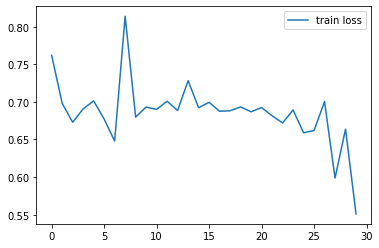

In [ ]:
plt.plot(train_loss,label="train loss")
plt.legend()
plt.show()

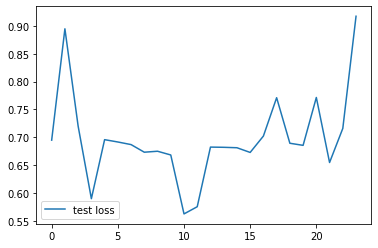

In [ ]:
plt.plot(test,label="test loss")
plt.legend()
plt.show()

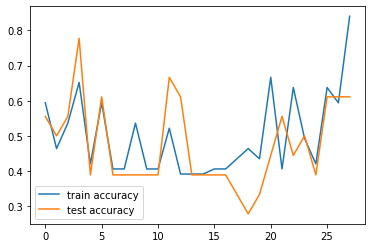

In [ ]:
plt.plot(train_accuracies[2:],label="train accuracy")
plt.plot(val_accuracies[2:],label="test accuracy")
plt.legend()
plt.show()

In [ ]:
from google.colab import files
th.save(model.state_dict(),"model3.pt" )


In [116]:
files.download("model3.pt")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Initialized empty Git repository in /content/gdrive/MyDrive/NAAMII/.git/


BBS1		  Data.csv	  model1.pt  model3.pt
csv_script.ipynb  Eye2Gene.ipynb  model2.pt  WT


On branch main
Changes to be committed:
  (use "git reset HEAD <file>..." to unstage)

	modified:   Eye2Gene.ipynb

Untracked files:
  (use "git add <file>..." to include in what will be committed)

	BBS1/
	WT/
	model1.pt
	model2.pt
	model3.pt



[main ca7c0bc] Additional files added
 1 file changed, 1 insertion(+), 1 deletion(-)
 rewrite Eye2Gene.ipynb (95%)


fatal: remote origin already exists.
fatal: could not read Username for 'https://github.com': No such device or address
